Global Annual Electric Vehicle Sales (millions) Forecast

21:39:12 - cmdstanpy - INFO - Chain [1] start processing
21:39:13 - cmdstanpy - INFO - Chain [1] done processing
c:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters


✅ Final Model Performance:
📊 R² Score: 0.9923
📊 Mean Absolute Error (MAE): 247103.54


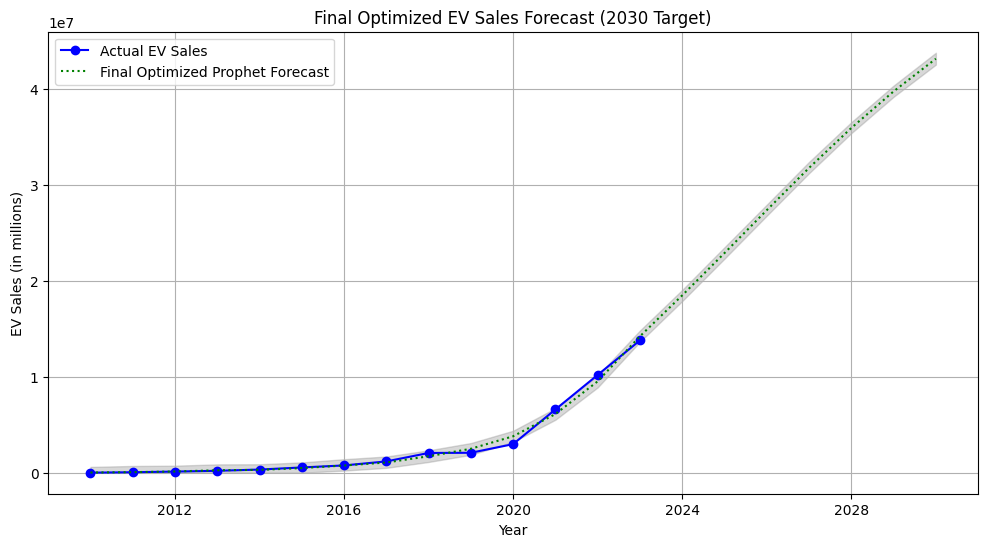

✅ Final Optimized Forecast Saved at: C:\Users\MSI\Desktop\Critical_mineral\Output\EV_forecast_2030.csv


In [2]:
# ==================================================
# ✅ Import Necessary Libraries
# ==================================================    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor

# ==================================================
# ✅ Step 1: Load the New Dataset (6.csv)
# ==================================================
file_path = r"C:\Users\MSI\Desktop\Critical_mineral\data\data.csv"

# ✅ Load Data
electricity_data = pd.read_csv(file_path, parse_dates=["Year"])
electricity_data.rename(columns={"Year": "year",
                                 "Electric cars sold": "ev_sales",
                                 "Electric car stocks": "ev_stocks",
                                 "Electricity from solar - TWh (adapted for visualization of chart electricity-prod-source-stacked)": "solar",
                                 "Lithium-ion Battery Price Data": "battery_price"}, inplace=True)

electricity_data.set_index("year", inplace=True)

# ✅ Define Selected Features
filtered_features = ["ev_stocks", "solar", "battery_price"]

# ==================================================
# ✅ Step 2: Apply Scaling & Adjustments
# ==================================================
scaler = MinMaxScaler()
electricity_data[filtered_features] = scaler.fit_transform(electricity_data[filtered_features])

# ✅ Scale Down `solar` for better contribution balance
if "solar" in electricity_data.columns:
    electricity_data["solar"] = np.log1p(electricity_data["solar"]) / 30  

# ✅ Restore Cap for Balanced Growth
electricity_data["cap"] = electricity_data["ev_sales"].max() * 2.5  # Adjust cap based on max sales
electricity_data["floor"] = 2.5e5  
electricity_data["cap"] = np.maximum(electricity_data["cap"], electricity_data["floor"] + 1)

# ✅ Prepare Data for Prophet Model
prophet_data = electricity_data.reset_index()[['year', "ev_sales", 'cap', 'floor'] + filtered_features]
prophet_data.rename(columns={'year': 'ds', "ev_sales": 'y'}, inplace=True)

# ==================================================
# ✅ Step 3: Prophet Forecasting
# ==================================================
prophet_model = Prophet(
    growth='logistic',
    changepoint_prior_scale=0.3,  
    seasonality_mode="additive",
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    interval_width=0.90,
    n_changepoints=25  
)

# ✅ Add Selected Features as Regressors
for feature in filtered_features:
    prophet_model.add_regressor(feature)

# ✅ Fit Prophet Model
prophet_model.fit(prophet_data)

# ✅ Future Forecast Limited to 2030
future = prophet_model.make_future_dataframe(periods=7, freq='YS')  # Forecast for 2024-2030
future["cap"] = electricity_data["cap"].max()
future["floor"] = 2.5e5  

# ==================================================
# ✅ Step 4: Feature Projections (ARIMA + XGBoost Mix)
# ==================================================
for feature in filtered_features:
    values = electricity_data[feature].dropna()

    if len(values) > 5:  
        try:
            # ARIMA Forecasting
            arima_model = ARIMA(values, order=(2,1,2))
            arima_fit = arima_model.fit()
            arima_forecast = arima_fit.forecast(steps=7)

            # XGBoost Forecasting
            X_train = np.arange(len(values)).reshape(-1, 1)
            y_train = values.values

            xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
            xgb_model.fit(X_train, y_train)

            future_X = np.arange(len(values) + 7).reshape(-1, 1)
            xgb_forecast = xgb_model.predict(future_X)[-7:]

            # Blend ARIMA + XGBoost 50/50
            hybrid_forecast = (0.5 * arima_forecast) + (0.5 * xgb_forecast)

            # Append to future dataframe
            full_forecast = np.append(values.values, hybrid_forecast)
            future[feature] = full_forecast[-len(future):]  

        except Exception as e:
            print(f"Feature {feature} failed to forecast: {e}")
            future[feature] = max(values.iloc[-1], 0)  
    else:
        future[feature] = max(values.iloc[-1], 0)  

# ✅ Generate Forecast
forecast = prophet_model.predict(future)

# ✅ Remove Negative Predictions
forecast["yhat"] = forecast["yhat"].clip(lower=0)
forecast["yhat_lower"] = forecast["yhat_lower"].clip(lower=0)
forecast["yhat_upper"] = forecast["yhat_upper"].clip(lower=0)

# ✅ Clip `extra_regressors_additive` to Avoid Negative Influence
forecast["extra_regressors_additive"] = forecast["extra_regressors_additive"].clip(lower=0)

# ==================================================
# ✅ Step 5: Model Evaluation
# ==================================================
actual = electricity_data.loc[electricity_data.index <= "2023", "ev_sales"]
predicted = forecast.loc[forecast["ds"] <= "2023", "yhat"]

# Compute Evaluation Metrics
r2 = r2_score(actual, predicted)
mae = mean_absolute_error(actual, predicted)

print(f"\n✅ Final Model Performance:")
print(f"📊 R² Score: {r2:.4f}")
print(f"📊 Mean Absolute Error (MAE): {mae:.2f}")

# ==================================================
# ✅ Step 6: Plot Updated Forecast Results
# ==================================================
plt.figure(figsize=(12, 6))
plt.plot(electricity_data.index, electricity_data["ev_sales"], label="Actual EV Sales", marker="o", color="blue")
plt.plot(forecast["ds"], forecast["yhat"], label="Final Optimized Prophet Forecast", linestyle="dotted", color="green")
plt.fill_between(forecast["ds"], forecast["yhat_lower"], forecast["yhat_upper"], color="gray", alpha=0.3)
plt.title("Final Optimized EV Sales Forecast (2030 Target)")
plt.xlabel("Year")
plt.ylabel("EV Sales (in millions)")
plt.legend()
plt.grid(True)
plt.show()

# ==================================================
# ✅ Step 7: Save Final Optimized Forecast Results
# ==================================================
forecast_output_path = r"C:\Users\MSI\Desktop\Critical_mineral\Output\EV_forecast_2030.csv"
forecast.to_csv(forecast_output_path, index=False)

print(f"✅ Final Optimized Forecast Saved at: {forecast_output_path}")


In [3]:
print("\n✅ Forecasted EV Sales from 2024 to 2030 with Uncertainties:")
forecast_results = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)
print(forecast_results.to_string(index=False))



✅ Forecasted EV Sales from 2024 to 2030 with Uncertainties:
        ds         yhat   yhat_lower   yhat_upper
2024-01-01 1.849339e+07 1.789630e+07 1.906149e+07
2025-01-01 2.291159e+07 2.232647e+07 2.351668e+07
2026-01-01 2.738136e+07 2.679712e+07 2.795684e+07
2027-01-01 3.178440e+07 3.122982e+07 3.240792e+07
2028-01-01 3.594612e+07 3.540208e+07 3.654732e+07
2029-01-01 3.976788e+07 3.920303e+07 4.037096e+07
2030-01-01 4.317068e+07 4.255760e+07 4.379583e+07


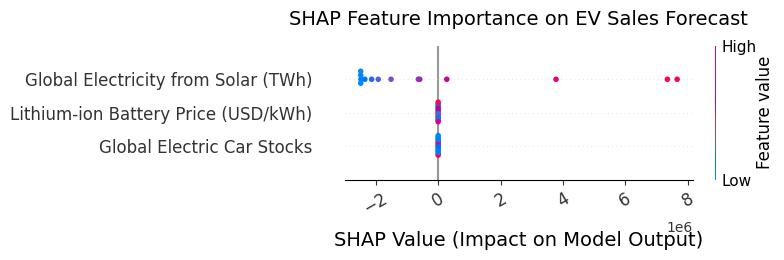

In [4]:
# ==================================================
# ✅ SHAP Summary Plot (Using Fixed Features)
# ==================================================
import shap
import xgboost as xgb
import matplotlib.pyplot as plt

# ✅ Define Feature Mapping with Full Names
feature_mapping = {
    "solar": "Global Electricity from Solar (TWh)",
    "ev_stocks": "Global Electric Car Stocks",
    "battery_price": "Lithium-ion Battery Price (USD/kWh)"
}

# ✅ Select Features & Target
X = electricity_data[list(feature_mapping.keys())].dropna().rename(columns=feature_mapping)
y = electricity_data["ev_sales"].dropna()  # Updated to match the correct column name

# ✅ Train an XGBoost Model
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, reg_lambda=10)
xgb_model.fit(X, y)

# ✅ Compute SHAP Values
explainer = shap.Explainer(xgb_model, X)
shap_values = explainer(X)

# ✅ SHAP Summary Plot with Full Feature Names
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, X, show=False)

# ✅ Adjust X-Axis Labels
plt.xticks(fontsize=12, rotation=30)
plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=14, labelpad=10)
plt.yticks(fontsize=12)
plt.title("SHAP Feature Importance on EV Sales Forecast", fontsize=14, pad=15)

# ✅ Apply Layout Fixes
plt.tight_layout()
plt.show()


In [5]:
print(f"AIC for ARIMA model: {arima_fit.aic}")


AIC for ARIMA model: -60.475928286953675
